# Week 5 Exercises - Solutions

Today, we'll be exploring deep neural networks and applying them to data related to the COMPAS algorithm. I got this data [here](https://github.com/propublica/compas-analysis), in case you're interested in exploring it on your own!

## Setting up the Environment

Clone the `unit3` repository from GitHub and install dependencies in requirements.txt [(instructions here, just in case)](http://web.stanford.edu/class/cs21si/setup.html).

Run any code below by highlighting it and hitting `Shift + Enter`. Import the libraries below.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras import regularizers
from keras import backend as K
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

# fix random seed for reproducibility
np.random.seed(1337)

Using Theano backend.


## Read in Data

In [2]:
filename = "resources/compas-scores.csv"

# load data
data = pd.read_csv(filename, header = 0)

# select fields we want
fields_of_interest = ['name', 'sex', 'age', 'race', 'priors_count', 'c_charge_desc', 
                      'v_decile_score', 'decile_score', 'is_violent_recid', 'is_recid']
data = data[fields_of_interest]
data.columns = ['name', 'sex', 'age', 'race', 'num_priors', 'charge', 
                'violence_score', 'recidivism_score', 'violence_true', 'recidivism_true']

# remove records with missing scores
data = data.loc[(data.violence_score != -1) & (data.recidivism_score != -1)]
data = data.loc[(data.violence_true != -1) & (data.recidivism_true != -1)]
print(data)

                         name     sex  age              race  num_priors  \
0            miguel hernandez    Male   69             Other           0   
2                 kevon dixon    Male   34  African-American           0   
3                    ed philo    Male   24  African-American           4   
4                 marcu brown    Male   23  African-American           1   
5          bouthy pierrelouis    Male   43             Other           2   
6                marsha miles    Male   44             Other           0   
7               edward riddle    Male   41         Caucasian          14   
8              steven stewart    Male   43             Other           3   
9            elizabeth thieme  Female   39         Caucasian           0   
10          darrell blackburn    Male   20         Caucasian           0   
11                 jamie good  Female   26         Caucasian           0   
12                  bo bradac    Male   21         Caucasian           1   
13          

## Jupyter Exercise 1: Visualize the Data

With the increasing availability of rich data sets encoding several features, it's difficult to extract useful knowledge just by looking at the numbers. This is where data visualizations come in. 

In [3]:
# races of interest
races = ['African-American', 'Caucasian', 'Hispanic']
colors = ['magenta', 'yellow', 'cyan']

#########################################################
# Counts number of people per race. Plots as bar graph.
#########################################################
def plot_racial_distrib():
    race_indices = [1,2,3]
    race_population = [(data.loc[data['race'] == race].shape[0]) for race in races]

    plt.bar(race_indices, race_population, align='center', color = colors)
    plt.xticks(race_indices, races)
    plt.title('Racial Distribution of COMPAS Defendants')
    plt.rcParams["figure.figsize"] = [15, 5]
    plt.show()

#########################################################
# Plots input feature by race as bar graph.
#########################################################
def plot_feature_by_race(feature, normalized = True):
    # bar chart parameters
    width = 0.25
    groups = sorted(data[feature].unique(), key=int)
    deciles = np.arange(1, len(groups) + 1)
    # deciles = np.arange(1, 11) # for each of the 10 scores
    
    if normalized:
        race_population = [(data.loc[data['race'] == race].shape[0]) for race in races]
    else:
        race_population = [1 for race in races]
    
    race_bars = []
    for i in range(len(races)):
        race_data = data.loc[data['race'] == races[i]]
        bar = plt.bar(deciles + (i-1)*width, race_data[feature].value_counts()/race_population[i], 
                      width, color = colors[i])
        race_bars.append(bar)

    plt.title('COMPAS ' + feature + ' by Race')
    plt.xticks(deciles + width / 2, groups)
    plt.legend(tuple(bar for bar in race_bars), tuple(races))
    plt.rcParams["figure.figsize"] = [15, 5]

    plt.show()

**Your task:** Using the functions defined above, plot the racial distribution of defendants in our database. Also plot the violence and recidivism COMPAS scores by race. You should see that African-Americans are disproportionately assigned higher recidivism and violence scores, compared to Caucasians and Hispanics.

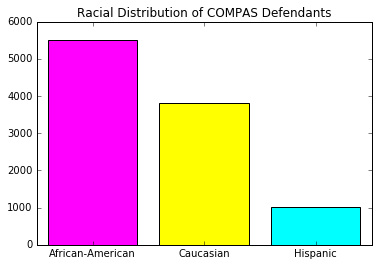

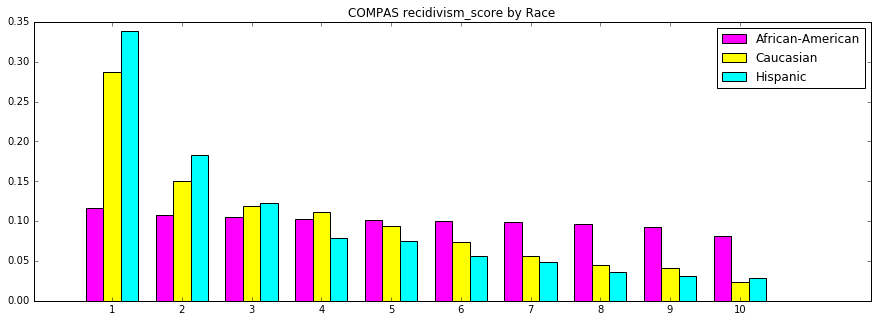

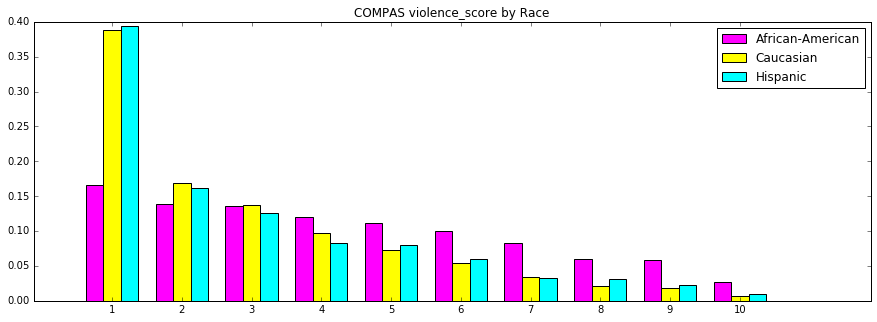

In [4]:
# YOUR CODE HERE:
plot_racial_distrib()
plot_feature_by_race('recidivism_score')
plot_feature_by_race('violence_score')
# END CODE

## Clean up the Data a Little More

In [5]:
# convert strings to numerical values
races = ['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
sex_classes = {'Male': 0, 'Female' : 1}
race_classes = {races[i]: i for i in range(len(races))}

# 'Other': 0, 'Caucasian': 1, 'African-American': 2, 'Hispanic': 3, 'Asian': 4, 'Native American': 5}
data['sex'] = data['sex'].apply(lambda x: sex_classes[x])
data['race'] = data['race'].apply(lambda x: race_classes[x])
# threshold and binarize scores
data['violence_score'] = data['violence_score'].apply(lambda x: 0 if x <= 5 else 1)
data['recidivism_score'] = data['recidivism_score'].apply(lambda x: 0 if x <= 5 else 1)
print(data)

# convert pandas dataframe to numpy array for easier processing
data = data.values

                         name  sex  age  race  num_priors  \
0            miguel hernandez    0   69     5           0   
2                 kevon dixon    0   34     0           0   
3                    ed philo    0   24     0           4   
4                 marcu brown    0   23     0           1   
5          bouthy pierrelouis    0   43     5           2   
6                marsha miles    0   44     5           0   
7               edward riddle    0   41     2          14   
8              steven stewart    0   43     5           3   
9            elizabeth thieme    1   39     2           0   
10          darrell blackburn    0   20     2           0   
11                 jamie good    1   26     2           0   
12                  bo bradac    0   21     2           1   
13             benjamin franc    0   27     2           0   
14             ellyaher lanza    0   23     0           3   
15            kortney coleman    1   37     2           0   
16                 kyle 

## Jupyter Exercise 2: Partition into Train and Test Sets

The scores above have been thresholded and binarized (values > 5 are now 1, others are 0). We will focus on predicting recidivism scores. This is now a binary classification problem where our inputs are sex, age, race, and number of prior convictions. Our output is 1 (high risk of recidivism) or 0 (low risk of recidivism). The entire dataset has already been split into inputs (X) and outputs (y). 
 
**Your task:** Partition the dataset into two sets: train (80%) and test (20%). The validation split will happen later. Assume the records have already been shuffled. Use the function `get_rows()` defined below.

In [6]:
# split into input (X) and output (Y) variables
X = data[:,1:5] # sex, age, race, num_priors
y = data[:,7] # recidivism_score

num_train = int(math.ceil(X.shape[0]*0.8))
num_test = int(math.floor(X.shape[0]*0.2))

#########################################################
# Returns the specified records of a given array, from
# row_start to row_start + num_rows - 1 (inclusive).
#########################################################
def get_rows(dataset, row_start, num_rows):
    return dataset[row_start:row_start + num_rows]

In [7]:
# YOUR CODE HERE:
X_train = get_rows(X, 0, num_train)
y_train = get_rows(y, 0, num_train)

X_test = get_rows(X, num_train, num_test)
y_test = get_rows(y, num_train, num_test)
# END CODE

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(X_train.shape[0], 'records in train set')
print(X_test.shape[0], 'records in test set')
print(X.shape[0], 'records in total')

8822 records in train set
2205 records in test set
11027 records in total


## Jupyter Exercise 3: Create a Baseline Model

**Your task:** At this point, we're ready to create a basic neural network classifier using Keras. Your model should have 4 layers, of sizes 50, 100, 50, and `num_classes`. All layers, save the last one, should use a ReLU activation function. The last layer should use softmax. Check this [guide](https://keras.io/getting-started/sequential-model-guide/) out to get started.

In [8]:
batch_size = 256
epochs = 15
learning_rate = 5e-2

#########################################################
# Initializes baseline neural network with 4 layers.
# ReLU and Softmax activations. Cross-entropy loss.
#########################################################
def baseline_classifier(learning_rate):
    # create model
    model_baseline = Sequential()

    # YOUR CODE HERE:
    model_baseline.add(Dense(50, input_dim = X.shape[1], activation = 'relu')) 
    model_baseline.add(Dense(100, activation = 'relu')) 
    model_baseline.add(Dense(50, activation = 'relu')) 
    model_baseline.add(Dense(num_classes, activation = 'softmax'))
    # END CODE

    # compile model
    sgd = keras.optimizers.SGD(lr = learning_rate)
    model_baseline.compile(loss = keras.losses.categorical_crossentropy, 
                  optimizer = sgd, metrics=['accuracy'])
    
    return model_baseline

model_baseline = baseline_classifier(learning_rate)

## Jupyter Exercise 4: Train and Evaluate the Baseline Model

**Your task:** Use the `eval()` function below to train and evaluate our baseline model. The return value of `eval()` is a tuple of loss and accuracy. Print both of these. In `eval()`, feel free to change the value of the `verbose` parameter. When `verbose = 0`, no information is printed. When it's 5, a lot of detailed information about the training process gets printed. Your test accuracy for this basic model should be around 37%.

Note that a parameter is `model.fit()` is `validation_split`. This takes a float from 0 to 1, representing the percentage of the training set to use for validation. Why do we need a validation set? More than training performance, we are interested in how our model does on unseen data. We can split data into only training and test. But if we then optimize our model using results from the test set, our test set can no longer be considered unseen data. As a workaround, we split our dataset into train, validation, and test. This way, we can optimize on our validation set, and only touch our test set at the very end.

In [10]:
#########################################################
# Trains and evaluates given model. Returns loss and 
# accuracy.
#########################################################
def eval(model, verb = 2):
    # fit the model
    model.fit(X_train, y_train, 
              epochs = epochs, 
              batch_size = batch_size,          
              validation_split = 0.1,
              verbose = verb,
              shuffle = False)
    
    # evaluate the model
    scores = model.evaluate(X_test, y_test)
    
    return scores

# YOUR CODE HERE:
loss, acc = eval(model_baseline, verb = 0)
print('\n\nTest loss:', loss)
print('Test accuracy:', acc)
# END CODE

  32/2205 [..............................] - ETA: 0s

Test loss: 10.19716249928723
Test accuracy: 0.3673469387619944


## Jupyter Exercise 5: Introduce Regularization

Sometimes our train accuracies are consistently higher than our test accuracy.  We might also see train losses that continue to decrease while the validation losses hit a minimum then increase. Both of these things are indicators of overfitting and poor model generalization. Regularization is a way to fix this. Regularization reduces overfitting by adding a penalty to the loss function. By adding this penalty, the model is trained such that it does not learn interdependent sets of features weights.

**Your task:** Add L2 regularization to each hidden layer of our model. You may want to refer to the [Keras documentation about regularizers](https://keras.io/regularizers/). You can see up to a 30% gain in test accuracy after adding in regularization.

In [11]:
reg_strength = 0.15

#########################################################
# Initializes neural network with L2 regularization.
#########################################################
def regularized_classifier(learning_rate, reg_strength):
    # create model
    model_regularized = Sequential()

    # YOUR CODE HERE:
    model_regularized.add(Dense(50, input_dim = X.shape[1], activation = 'relu')) 
    model_regularized.add(Dense(100, activation = 'relu', kernel_regularizer=regularizers.l2(reg_strength))) 
    model_regularized.add(Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(reg_strength))) 
    model_regularized.add(Dense(num_classes, activation = 'softmax'))
    # END CODE
    
    # compile model
    sgd = keras.optimizers.SGD(lr = learning_rate)
    model_regularized.compile(loss = keras.losses.categorical_crossentropy, 
                  optimizer = sgd, metrics=['accuracy'])
    
    return model_regularized

model_regularized = regularized_classifier(learning_rate, reg_strength)

loss, acc = eval(model_regularized, verb = 0)
print('\n\nTest loss:', loss)
print('Test accuracy:', acc)

  32/2205 [..............................] - ETA: 0s

Test loss: 0.9440328757508812
Test accuracy: 0.6761904762986025


## Jupyter Exercise 6: Introduce Dropout

Dropout is another regularization technique to prevent over-fitting. Dropout randomly selects neurons to ignore during training. In other words, they are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. 

**Your task:** Remove the regularization, and this time around, add dropout for the input layer. You may want to refer to the [Keras documentation about Dropout layer](https://keras.io/layers/core/). You may see up to a 5% increase in test accuracy compared to the regularization model.

In [12]:
dropout_strength = 0.1

#########################################################
# Initializes neural network with dropout.
#########################################################
def dropout_classifier(learning_rate, dropout_strength):
    # create model
    model_dropout = Sequential()

    # YOUR CODE HERE:
    model_dropout.add(Dropout(dropout_strength, input_shape = (X.shape[1],)))
    model_dropout.add(Dense(50, activation = 'relu')) 
    model_dropout.add(Dense(100, activation = 'relu')) 
    model_dropout.add(Dense(50, activation = 'relu')) 
    model_dropout.add(Dense(num_classes, activation = 'softmax'))
    # END CODE
    
    # compile model
    sgd = keras.optimizers.SGD(lr = learning_rate)
    model_dropout.compile(loss = keras.losses.categorical_crossentropy, 
                  optimizer = sgd, metrics=['accuracy'])
    
    return model_dropout

model_dropout = dropout_classifier(learning_rate, dropout_strength)

loss, acc = eval(model_dropout, verb = 0)
print('\n\nTest loss:', loss)
print('Test accuracy:', acc)

  32/2205 [..............................] - ETA: 0s

Test loss: 0.58830770601491
Test accuracy: 0.704308390130802


## Jupyter Exercise 7: Introduce Batch Normalization

Batch Normalization is used to help remedy “covariate shifts”, or changes in the distribution of function’s domain.
They help keep activations in the zero-mean unit-variance range. You might use batch normalization for the same reasons that you normalized the entire dataset initially.

**Your task:** For our final exercise, keep dropout. Add batch normalization after the first dense layer. You may want to refer to the [Keras documentation about the BatchNorm layer](https://keras.io/layers/normalization/). You can see up to a 5% increase in test accuracy compared to the dropout-only model.

In [13]:
#########################################################
# Initializes neural network with dropout.
#########################################################
def batchnorm_classifier(learning_rate, dropout_strength):
    # create model
    model_batchnorm = Sequential()

    # YOUR CODE HERE:
    model_batchnorm.add(Dropout(dropout_strength, input_shape = (X.shape[1],)))
    model_batchnorm.add(Dense(50, activation = 'relu')) 
    model_batchnorm.add(BatchNormalization())
    model_batchnorm.add(Dense(100, activation = 'relu')) 
    model_batchnorm.add(Dense(50, activation = 'relu')) 
    model_batchnorm.add(Dense(num_classes, activation = 'softmax'))
    # END CODE
    
    # compile model
    sgd = keras.optimizers.SGD(lr = learning_rate)
    model_batchnorm.compile(loss = keras.losses.categorical_crossentropy, 
                  optimizer = sgd, metrics=['accuracy'])
    
    return model_batchnorm

model_batchnorm = batchnorm_classifier(learning_rate, dropout_strength)

loss, acc = eval(model_batchnorm, verb = 0)
print('\n\nTest loss:', loss)
print('Test accuracy:', acc)

  32/2205 [..............................] - ETA: 0s

Test loss: 0.5208241713830943
Test accuracy: 0.7569160995840215
